In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")


    except RuntimeError as e:
        print(e)





1 Physical GPUs, 1 Logical GPUs


In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce 940MX (UUID: GPU-ffb5177f-d8ce-71bb-2ac1-8bdd43322698)


# DATA PREPROCESSING

In [3]:
url_train = "/content/drive/MyDrive/suicide_data/train.csv"
url_test  = "/content/drive/MyDrive/suicide_data/test.csv"
url_val   = "/content/drive/MyDrive/suicide_data/val.csv"

In [4]:
df_train = pd.read_csv(url_train)

In [5]:
df_train

,Unnamed: 0,text,class
0,343589,Need Help Dealing With Sertraline WithdrawalI ...,suicide
1,182223,"Maybe.Maybe if I bleedout ever liter of blood,...",depression
2,73111,I have become so lonely I'd be happy if someon...,depression
3,165519,I don't wanna be 18 How am I gonna scare creep...,non-suicide
4,267706,I seriously want to die because im ugly and aw...,suicide
...,...,...,...
222794,82624,I think I just can't do itI have nothing. I sp...,suicide
222795,117120,to all homophobes🙄‼️ what are u even mad at🤣🤣🤣...,non-suicide
222796,66951,seattle suicide tomorrowHey guys. I was stayin...,suicide
222797,125585,I have nothing to live forI really don't. I'm ...,suicide


In [6]:
df_test = pd.read_csv(url_test)
df_test

,Unnamed: 0,text,class
0,50414,I cut my thumb and now have a fabric plaster o...,non-suicide
1,344706,Kinda hot in my roomBut some body warmth would...,depression
2,49641,Something my ex said that I can't shake.Earlie...,depression
3,53647,15 and suicidalI've been thinking about this f...,suicide
4,193976,Hopeless and lostFeeling incredibly hopeless a...,depression
...,...,...,...
69620,192645,just want this to endi’m so so so so so tired ...,suicide
69621,318180,depressed and aloneMy life has been nothing bu...,depression
69622,104141,Hello SWI'll just dive right in to this.\n\nI'...,suicide
69623,42286,"I was having one of my better days, until I sa...",depression


In [7]:
df_val = pd.read_csv(url_val)
df_val

,Unnamed: 0,text,class
0,32399,I’ve been feeling down Is it ok to feel this w...,non-suicide
1,256078,Feminism is a bad name It should be called equ...,non-suicide
2,113421,Feeling uselessEvery time my life starts impro...,suicide
3,102597,What's the point?When doing anything this is t...,depression
4,58266,"So it begins. Stay strong out there, and good ...",non-suicide
...,...,...,...
55695,75858,Please please please please please please plea...,suicide
55696,126122,Tell the person above me that they are very co...,non-suicide
55697,43485,Medication and therapy don't help.Meditating d...,depression
55698,138463,I’m aloneI went to my school dance last night ...,suicide


In [8]:
df_train = df_train.drop(['Unnamed: 0'] , axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)
df_val = df_val.drop(['Unnamed: 0'], axis=1)

In [9]:
df_train.rename(columns = {'class':'sentiment'}, inplace = True)
df_test.rename(columns = {'class':'sentiment'}, inplace = True)
df_val.rename(columns = {'class':'sentiment'}, inplace = True)

## Assesment of the data

### Training

In [10]:
df_train.sentiment.value_counts()

depression     74280
suicide        74264
non-suicide    74248
Name: sentiment, dtype: int64

In [11]:
df_train.sentiment.value_counts() / df_train.shape[0] *100

depression     33.339467
suicide        33.332286
non-suicide    33.325105
Name: sentiment, dtype: float64

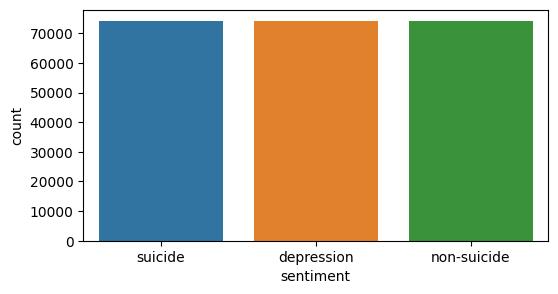

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,3))
sns.countplot(x='sentiment', data=df_train);

In [13]:
df_train.isnull().sum()

text         1
sentiment    7
dtype: int64

In [14]:
df_train.fillna('non-suicide' , inplace=True)

In [15]:
df_train.duplicated().sum()

0

In [16]:
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [17]:
df_train[df_train['text'].duplicated() == True]

,text,sentiment


In [18]:
index = df_train[df_train['text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [19]:
df_train.duplicated().sum()

0

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

6      6430
7      6302
5      6210
8      6108
9      5918
       ... 
121       2
120       2
122       1
115       1
123       1
Name: stop_words, Length: 123, dtype: int64

### Test Set

In [22]:
df_test.sentiment.value_counts()

non-suicide    23277
depression     23207
suicide        23137
Name: sentiment, dtype: int64

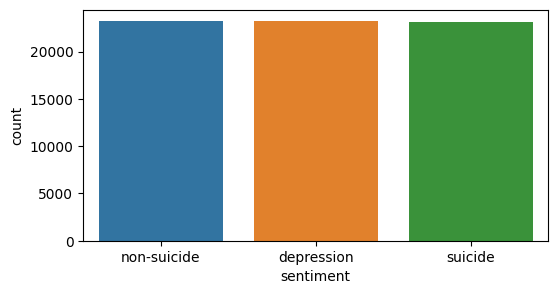

In [23]:
plt.figure(figsize=(6,3))
sns.countplot(x='sentiment', data=df_test);

In [24]:
df_test.isnull().sum()

text         0
sentiment    4
dtype: int64

In [25]:
df_test.fillna('non-suicide' , inplace=True)

In [26]:
df_test.duplicated().sum()

0

In [27]:
temp =df_test.copy()
temp['stop_words'] = temp['text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

6      2056
7      2033
5      1969
8      1908
4      1847
       ... 
117       2
113       2
115       1
119       1
114       1
Name: stop_words, Length: 118, dtype: int64

### Validation set

In [28]:
df_val.sentiment.value_counts()

suicide        18636
depression     18549
non-suicide    18512
Name: sentiment, dtype: int64

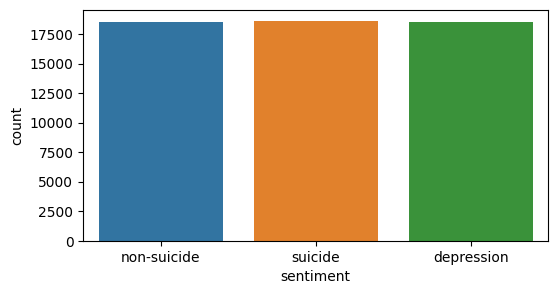

In [29]:
plt.figure(figsize=(6,3))
sns.countplot(x='sentiment', data=df_val);

In [30]:
df_val.isnull().sum()

text         0
sentiment    3
dtype: int64

In [31]:
df_val.fillna('non-suicide' , inplace=True)

In [32]:
df_val.duplicated().sum()

0

In [33]:
temp =df_val.copy()
temp['stop_words'] = temp['sentiment'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

0    55700
Name: stop_words, dtype: int64

In [34]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""

    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )

    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]

    # Return the filtered DataFrame
    return diff_df

In [35]:
dataframe_difference(df_train, df_test, which='both')

,text,sentiment,_merge


In [36]:
dataframe_difference(df_train, df_val, which='both')

,text,sentiment,_merge


In [37]:
dataframe_difference(df_test, df_val, which='both')

,text,sentiment,_merge


### Cleaning

In [38]:
nltk.download('wordnet')
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [39]:
def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

In [40]:
def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

In [41]:
def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

In [42]:
import re
def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

In [43]:
def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [44]:
def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

In [45]:
def normalize_text(df):
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : Removing_numbers(text))
    df.text=df.text.apply(lambda text : Removing_punctuations(text))
    df.text=df.text.apply(lambda text : Removing_urls(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df

In [46]:
def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [47]:
normalized_sentence("my name is  JAY Extremely busy weekend. So much work to do. C")

'name jay extremely busy weekend much work do c'

In [48]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [49]:
df_train

,text,sentiment
0,need help dealing sertraline withdrawali recen...,suicide
1,maybe maybe bleedout ever liter blood rid you,depression
2,become lonely i d happy someone flirted jokeli...,depression
3,wanna gonna scare creepy fuck dm now i d say i...,non-suicide
4,seriously want die im ugly awkward these feeli...,suicide
...,...,...
222794,think can t iti nothing spend day home work go...,suicide
222795,homophobes🙄‼️ u even mad at🤣🤣🤣🤣🤣🤣 he’s getting...,non-suicide
222796,seattle suicide tomorrowhey guy staying family...,suicide
222797,nothing live fori really don t i m disabled lo...,suicide


# MODEL

## 1. RNN model

### Tokenizing

In [50]:
X_train = df_train['text']
y_train = df_train['sentiment']

X_test = df_test['text']
y_test = df_test['sentiment']

X_val = df_val['text']
y_val = df_val['sentiment']


In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


In [52]:
y_train

array([2, 0, 0, ..., 2, 2, 2])

In [53]:
print(set(y_train))

{0, 1, 2}


In [54]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


In [55]:
print(y_train)

[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [58]:
tokenizer.document_count

292424

In [59]:
tokenizer.word_index['towards']

648

In [60]:
tokenizer.texts_to_sequences(X_train[0].split())

[[47],
 [31],
 [684],
 [3361],
 [23996],
 [271],
 [348],
 [241],
 [3361],
 [4523],
 [14],
 [793],
 [381],
 [2314],
 [113],
 [616],
 [3768],
 [11],
 [77],
 [3969],
 [491],
 [378],
 [146],
 [14],
 [131],
 [125],
 [30],
 [831],
 [721],
 [675],
 [5562],
 [476],
 [10],
 [18],
 [11545],
 [11],
 [388],
 [111],
 [1298],
 [18],
 [699],
 [8517],
 [662],
 [102],
 [67],
 [29],
 [370],
 [6],
 [1234],
 [63],
 [355],
 [5137],
 [234],
 [181],
 [7522],
 [1194],
 [663],
 [370],
 [120],
 [653],
 [1088],
 [370],
 [1265],
 [104],
 [201],
 [111],
 [2632],
 [22396],
 [28],
 [5],
 [4],
 [528],
 [175],
 [111],
 [4],
 [188],
 [772],
 [480],
 [315],
 [772],
 [5563],
 [205],
 [1446],
 [1452],
 [4202],
 [104],
 [241],
 [323],
 [417],
 [21],
 [205],
 [5563],
 [537],
 [3496],
 [39],
 [480],
 [276],
 [16],
 [7],
 [5576],
 [1661],
 [8],
 [43],
 [17],
 [6],
 [57],
 [78],
 [433],
 [1067],
 [321],
 [8],
 [97],
 [244],
 [1151],
 [25],
 [37],
 [323],
 [945],
 [107],
 [2741],
 [1172],
 [118],
 [30],
 [95],
 [197],
 [311],
 

In [61]:
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
tokenizer.texts_to_matrix(X_train[0].split()).shape

(134, 194252)

In [63]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [64]:
df_test.shape

(69625, 2)

In [65]:
round(sum([len(i.split()) for i in df_train['text']])/len(df_train['text']))


91

In [66]:
X_train = pad_sequences(sequences_train, maxlen=250, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=250, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=250, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 194252


In [67]:
sequences_train[0]

[47,
 31,
 684,
 3361,
 23996,
 271,
 348,
 241,
 3361,
 4523,
 14,
 793,
 381,
 2314,
 113,
 616,
 3768,
 11,
 77,
 3969,
 491,
 378,
 146,
 14,
 131,
 125,
 30,
 831,
 721,
 675,
 5562,
 476,
 10,
 18,
 11545,
 11,
 388,
 111,
 1298,
 18,
 699,
 8517,
 662,
 102,
 67,
 29,
 370,
 6,
 1234,
 63,
 355,
 5137,
 234,
 181,
 7522,
 1194,
 663,
 370,
 120,
 653,
 1088,
 370,
 1265,
 104,
 201,
 111,
 2632,
 22396,
 28,
 5,
 4,
 528,
 175,
 111,
 4,
 188,
 772,
 480,
 315,
 772,
 5563,
 205,
 1446,
 1452,
 4202,
 104,
 241,
 323,
 417,
 21,
 205,
 5563,
 537,
 3496,
 39,
 480,
 276,
 16,
 7,
 5576,
 1661,
 8,
 43,
 17,
 6,
 57,
 78,
 433,
 1067,
 321,
 8,
 97,
 244,
 1151,
 25,
 37,
 323,
 945,
 107,
 2741,
 1172,
 118,
 30,
 95,
 197,
 311,
 244,
 14,
 487,
 6,
 77,
 161,
 175,
 14]

In [68]:
X_train[0]


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,    47,
          31,   684,  3361, 23996,   271,   348,   241,  3361,  4523,
          14,   793,

In [73]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional ,Embedding
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(input_dim=194200, # max_vocb
                             output_dim=200,
                             embeddings_initializer="uniform",
                             input_length=250, #max _len
                             name="embedding_1",trainable=False))
model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 200)          38840000  
                                                                 
 bidirectional_3 (Bidirectio  (None, 250, 128)         135680    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 250, 64)          41216     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                      

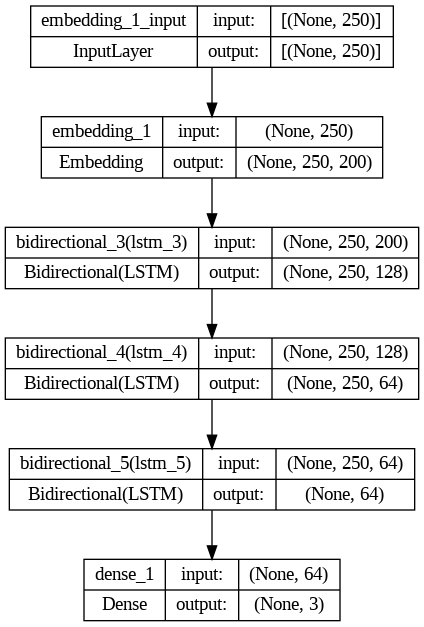

In [74]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, show_shapes=True)

In [76]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [77]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=5,
                    callbacks=[callback]
                   )

Epoch 1/5
871/871 [==============================] - 4413s 5s/step - loss: 0.7578 - accuracy: 0.6553 - val_loss: 0.6307 - val_accuracy: 0.7265
Epoch 2/5
871/871 [==============================] - 4386s 5s/step - loss: 0.6232 - accuracy: 0.7365 - val_loss: 0.5569 - val_accuracy: 0.7677
Epoch 3/5
871/871 [==============================] - 4364s 5s/step - loss: 0.5448 - accuracy: 0.7721 - val_loss: 0.5182 - val_accuracy: 0.7838
Epoch 4/5
871/871 [==============================] - 4368s 5s/step - loss: 0.5083 - accuracy: 0.7878 - val_loss: 0.4876 - val_accuracy: 0.7973
Epoch 5/5
871/871 [==============================] - 4275s 5s/step - loss: 0.4869 - accuracy: 0.7967 - val_loss: 0.4818 - val_accuracy: 0.8003


In [79]:
model.save('Suicide_detection_model(V1).h5')

In [82]:
def detect(sentence):
  print(sentence)
  sentence = normalized_sentence(sentence)
  sentence = tokenizer.texts_to_sequences([sentence])
  sentence = pad_sequences(sentence, maxlen=250, truncating='pre')
  result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
  proba =  np.max(model.predict(sentence))

  return(f"{result} : {proba}\n\n")


In [83]:
detect('i want to  kill myself')

i want to  kill myself
1/1 [==============================] - 0s 83ms/step


'suicide : 0.8506962656974792\n\n'

In [84]:
detect("what a lovely day")

what a lovely day
1/1 [==============================] - 0s 81ms/step


'non-suicide : 0.8146605491638184\n\n'

In [85]:
detect("man im so done!")

man im so done!
1/1 [==============================] - 0s 86ms/step


'non-suicide : 0.6326689124107361\n\n'

In [88]:
detect("evrything is hopeless.but i dont want to die")

evrything is hopeless.but i dont want to die
1/1 [==============================] - 0s 83ms/step


'suicide : 0.5929161310195923\n\n'